Land Use Regression Project 

Read in Chemical Data 

In [1]:
# Import packages 
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm



In [2]:
# Define Functions
# Note - functions are also defined as they are used in the tool below. If running any of the functions on fresh data, the user should copy this cell and run to create all functions and 
# use them as they please.
# Split between the control data and the chemical data
def split_col(ctrl_list, data): # Define split_col function
    ctrl_data = data.loc[ctrl_list,:] # Ctrl data split
    rest_data = data.drop(ctrl_list,0) # data split
    return(ctrl_data,rest_data) # Return data


# Subtract control means from the data
def sub_ctrl(controls, data, stat ):
    ctrlsum = controls.describe() # get summary statistics from the controls dataframe
    desc_stat = ctrlsum.loc[stat,:] # take the desired statistic from the description
    findf = pd.DataFrame(columns = data.columns) # Define an empty dataframe with the same columns as the data DF
    for index in data.index: # go through each observation in the data DF
        values = data.loc[index,:] # Get the initial value
        findf.loc[index] = values - desc_stat # assign the empty dataframe with values equal to the value - your desired stat
    for cols in findf.columns: # run through the columns in your dataframe
        findf.loc[findf[cols] < 0, cols] = 0 # if the said chemical is less than 0, assign it to 0
    return(findf)

# Determine total number of chemicals present in each sample
def my_recode(chemical, lim): # Define function to recode the chem data depending on whether the chemical is greater than 0
    if chemical > lim:
        return 1
    else:
        return 0

# Normalize Data
def normalizeme(df):
    x = df.values # get the initial values
    x = StandardScaler().fit_transform(x) # normalize the values
    print("""
    mean = {0}
    std = {1}
    """.format(np.mean(x), np.std(x))) # for the user to ensure the data is properly normalized
    return(x) 


# Run PCA
def init_pca(components, data):
    init = PCA(n_components = components) # initialize the PCA with n number of components
    cols = [] # set up an empty list for the number of columns
    for x in range(components): 
        cols.append('Dimension ' + str(x + 1)) # set up the column names with the appropriate number of columns
    princcomp_chem = init.fit_transform(data)# Run the PCA (note - this must be done on normalized data)
    p_Cdf = pd.DataFrame(data = princcomp_chem, columns=cols) # fit the PCA results into a DF with appropriate columns 
    return(p_Cdf, init)


# Plot out samples by how they load on two dimensions of the PCA
def scatter_pca(dimn,dimn2, iloc1, iloc2, pca_df, indexer, title = ''):
    plt.figure(figsize=(10,10))# Set up your plot
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 14) # Set the x and y tick values
    plt.xlabel('Principal Component - {}'.format(dimn), fontsize = 20)
    plt.ylabel('Principal Component - {}'.format(dimn2), fontsize = 20) # Set the x and y labels, using the user given dimension names
    plt.title(title) # add in the title
    plt.scatter(pca_df.loc[:,dimn], pca_df.loc[:,dimn2]) # Make the scatterplot using the user given dimensions
    annotate = list(indexer.index) # Get the index values from your indexer data frame
    for i, label in enumerate(annotate): # for index in the indexer
        xy  = (pca_df.iloc[i,iloc1], pca_df.iloc[i,iloc2]) # Get teh xy location using the index location of your dimensions
        plt.annotate(label, xy = xy) # put the label down


# Plot out eigenvalues from a initial Principal Component Analysis
def plot_eigen(pca_init,title): # Define a function for plotting the eigen values
    eig_vals = pca_init.explained_variance_ratio_ # Get the eigen value ratios
    newdf = pd.DataFrame() # Make an empty data frame
    for x in range(len(eig_vals)): # For x in the range of your eigen values
        newdf.loc['Dimension ' + str((int(x) + 1)),'eig_val'] = float(eig_vals[x]) # row location is the dimension number, second is the 'eig_val' column
    fig, axes = plt.subplots(figsize = (15,15)) # Make your plot window
    axes.bar(x = newdf.index, height= newdf['eig_val'], color = 'blue', alpha = 0.75) # Plot your bar chart 
    for x in range(len(list(newdf.index))): # for x in the range of your dataframe
        plt.text(list(newdf.index)[x],newdf['eig_val'][x] + 0.01,str(newdf['eig_val'][x] * 100)[0:5]) # put your eigen value ration * 100 (percent)
    plt.title(title) # Add in the title


def LU_recode(df_series): # Recode Land Use_Land Cover function (this is only optimized for the values I have, in future runs the user can add or replace values as needed)
    if df_series == 'Grassland': # conditional statememt
        x = 0 # recoded value
    if df_series == 'Developed':
        x = 1
    if df_series == 'Shrubland':
        x = 2
    return(x)

# Define a function to create a buffer then get the attributes from the original shapefile
def join_buff(buff_size, join_file, idfield):
    buffer = join_file.buffer(buff_size)# Make the original buffer
    buffer_1 = gpd.GeoDataFrame(index = [0], crs = join_file.crs, geometry = None) # Set an empty dataframe
    for x in range(len(buffer)): 
        buffer_1.loc[x,'geometry'] = buffer[x] # Set the new dataframes geoemtry to buffer
    buffer_1 = gpd.sjoin(join_file,buffer_1, how = 'inner', op = 'within') # join the buffer GDF with the original shapefile
    buffer_1 = buffer_1.drop_duplicates(idfield) # Drop any duplicates (take care of overlap)
    return(buffer_1)


# Get statistics using a buffer with an idfield and a raster file
def get_stats(buffer, raster, idfield):
    stats = pd.DataFrame(zonal_stats(buffer, raster)) # Run zonal stats using the user defined buffer and raster
    stats[idfield] = buffer[idfield] # Set the idfield for stats equal to the buffer field
    return(stats)


# Define a function to get a value from a raster at point file locations and return the original shapefile attributes
def get_ptst(points, raster, idfield,fieldname):
    stats = pd.DataFrame()# Make an empty data frame
    stats[fieldname] = point_query(points,raster)  # set the user defined field name to the raster value at x point
    stats[idfield] = points[idfield] # set the idfield to be the same as the point idfield
    return(stats)


    # Drop any correlated variables over a specified limit
# Caution - this function will drop any variables over your correlation limit. You should determine any variables that you really want to conserve before running this and combine afterwards
def drop_corr(data, corr_lim):
    corr_matrix = data.corr().abs() # get the original correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool)) # Determine the upper triangle of the correlation matrix 
    to_drop = [column for column in upper.columns if any(upper[column] >= corr_lim)] # if any columns to drop, set them here
    if len(to_drop) > 0: # if the to_drop variable is not none
        data.drop(to_drop, axis = 1, inplace = True) # drop variables
        print('Layers Dropped at correlation limit {}:'.format(corr_lim)) # print variables dropped
        for x in range(len(to_drop)):
            print(to_drop[x])
    else:
        print('No Variables to drop at correlation limit {}'.format(corr_lim))



# Define function to get correlation from each predictor variable to the dependent variable
def get_corr(df,df1,depend):
    d = df1[depend] # get the dependent variable from
    newdf = pd.DataFrame(columns=['variable','correlation','p-value']) # assign a new data frame to hold the results 
    for cols in df.columns:
        corr = pearsonr(df[cols],d) # get the pearson correlation
        df2 = {'variable':cols, 'correlation':corr[0], 'p-value':corr[1]} # assign the values to a dictionary
        newdf.loc[len(newdf),:] = df2 # assign the results to the newdf
    return(newdf)

# Backwards Stepwise Linear Regression
def step_reg_bac(y,x, plim = 0.05): 
    pvalues = pd.Series([1]) # Create a pandas series with, assign the only value to one 
    while pvalues[pvalues > plim].all(): # while any of the above series is greater than the p-limit
        est = sm.OLS(y,x) # get an initial regression using all varialbes
        res = est.fit() # fit the regression
        pvalues = res.summary2().tables[1]['P>|t|']
        dropcol = pvalues[pvalues == pvalues.max()].index[0] # assign the drop col to be the column with the highest p-value
        print('Evaluating variable ' + dropcol)
        if len(x.columns) == 1: # Model is not signficant, cannot be improved at all
            pvalues = pd.Series([plim - 1])
            print('Model is not significant')
            break
        if dropcol == 'const': # Don't want to drop the constant
            print("Can't drop Constant variable") 
            est = sm.OLS(y,x.iloc[:,1:]) #Evaluate the regression without the constant
            res = est.fit() # fit the regression again
            pvalues = res.summary2().tables[1]['P>|t|'] # Grab those p-values
            dropcol = pvalues[pvalues == pvalues.max()].index[0] # assign the new p-value
            print('Evaluating ' + dropcol + ' instead')
            if pvalues.max() < plim: # If that value is below the p-value, then the model is significant
                print("Model's already significant")
                break
            elif dropcol != 'const' and pvalues.max() > plim: # otherwise, drop the column and continue
                print('Variable Dropped ' + dropcol + " p-value: " + str(pvalues.max()))
                x = x.drop(dropcol,1)
                continue
        elif pvalues.max() < plim: # Model is significant! 
            print('Model is significant!') 
            break
        else:
            print('Variable Dropped ' + dropcol)
            x = x.drop(dropcol,1) # if the column is not the constant, just drop
    est = sm.OLS(y,x) 
    res = est.fit() # get the final regression significant regression
    return(res)

In [3]:
# Read in chemical wristband data
d_path = 'Data/'
chem_data = pd.read_csv(d_path + 'results.csv')
chem_data = chem_data.set_index('Chemical')
cancel_columns = ['Description','Notes','DIST','Angle','Landcover','LC_Desc'] # These columns won't be used in our PCA as they aren't numerical
chem_data = chem_data.drop(cancel_columns,1)
chem_data = chem_data.drop('CASRN',0) # Another not used row
# print out data (head if appropriate, print out the entire dataset if it's small enough)
chem_data

C:\Users\chris\AppData\Local\Temp/ipykernel_13404/731821366.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  chem_data = chem_data.drop(cancel_columns,1)
C:\Users\chris\AppData\Local\Temp/ipykernel_13404/731821366.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  chem_data = chem_data.drop('CASRN',0) # Another not used row


,1-Methylnaphthalene,1-Methylphenanthrene,1-Methylpyrene,"1,6-Dimethylnaphthalene",2-Methylnaphthalene,2-Methylphenanthrene,"2,4-Di-tert-butylphenol",4-Isopropylphenol,9-Fluorenone,"9,10-Anthraquinone",...,Dimethyl phthalate,Exaltolide [15-Pentadecanolide],Fluoranthene,Fluorene,Hydroxy-citronellal,"N,N-Diethyl-m-toluamide",Phthalimide,Pyrene,Quinoline,Retene
Chemical,,,,,,,,,,,,,,,,,,,,,
CN001,7.32,0,0,0,0,0,47.7,0,0,0,...,0,0,0,0,0,0,41.4,0,0,0
CN002,0,31.8,3.82,0,0,35,30.6,0,66.8,0,...,0,47.7,0,5.41,0,31.8,0,57.3,66.8,18.8
CN003,9.12,44,25.8,8.81,0,164,75.5,23.9,346,40.9,...,0,293,289,34.6,0,0,0,277,101,170
CN004,0,0,0,0,3.25,0,23,0,17.8,0,...,0,62.5,6.5,0,0,0,0,0,10.5,0
CN005,4,0,0,0,0,7,0,0,23.3,0,...,0,75,0,6.5,0,0,0,8.5,0,12.3
CN006,4.25,0,0,0,0,0,0,0,0,0,...,0,60,0,0,118,0,0,0,0,0
CN007,0,0,0,0,0,0,27.8,0,0,0,...,0,68.3,0,0,0,17.2,0,0,0,0
CN008,3.75,0,0,0,0,0,40,0,0,0,...,7,115,0,0,0,24.5,0,0,0,0
CN009,3.38,0,0,0,0,0,0,0,0,0,...,5.31,84.5,0,0,0,26.6,0,0,0,0


In [4]:
# Make a dataset of only your control points
ctrl_list = ['CN001', 'CN00A','CN00B','CN010'] # make your control index list
chem_data = chem_data.astype('float64') # Change the data type to float64 (if already done this line will have no effect)
def split_col(ctrl_list, data): # Define split_col function
    ctrl_data = data.loc[ctrl_list,:] # Ctrl data split
    rest_data = data.drop(ctrl_list,0) # data split
    return(ctrl_data,rest_data) # Return data
control, chem_data_noctrl = split_col(ctrl_list=ctrl_list, data=chem_data) # Run function
chem_data_noctrl
# control

C:\Users\chris\AppData\Local\Temp/ipykernel_13404/2448923012.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  rest_data = data.drop(ctrl_list,0) # data split


,1-Methylnaphthalene,1-Methylphenanthrene,1-Methylpyrene,"1,6-Dimethylnaphthalene",2-Methylnaphthalene,2-Methylphenanthrene,"2,4-Di-tert-butylphenol",4-Isopropylphenol,9-Fluorenone,"9,10-Anthraquinone",...,Dimethyl phthalate,Exaltolide [15-Pentadecanolide],Fluoranthene,Fluorene,Hydroxy-citronellal,"N,N-Diethyl-m-toluamide",Phthalimide,Pyrene,Quinoline,Retene
Chemical,,,,,,,,,,,,,,,,,,,,,
CN002,0.00,31.8,3.82,0.00,0.00,35.0,30.6,0.0,66.8,0.0,...,0.00,47.7,0.0,5.41,0.0,31.8,0.0,57.3,66.8,18.8
CN003,9.12,44.0,25.80,8.81,0.00,164.0,75.5,23.9,346.0,40.9,...,0.00,293.0,289.0,34.60,0.0,0.0,0.0,277.0,101.0,170.0
CN004,0.00,0.0,0.00,0.00,3.25,0.0,23.0,0.0,17.8,0.0,...,0.00,62.5,6.5,0.00,0.0,0.0,0.0,0.0,10.5,0.0
CN005,4.00,0.0,0.00,0.00,0.00,7.0,0.0,0.0,23.3,0.0,...,0.00,75.0,0.0,6.50,0.0,0.0,0.0,8.5,0.0,12.3
CN006,4.25,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,60.0,0.0,0.00,118.0,0.0,0.0,0.0,0.0,0.0
CN007,0.00,0.0,0.00,0.00,0.00,0.0,27.8,0.0,0.0,0.0,...,0.00,68.3,0.0,0.00,0.0,17.2,0.0,0.0,0.0,0.0
CN008,3.75,0.0,0.00,0.00,0.00,0.0,40.0,0.0,0.0,0.0,...,7.00,115.0,0.0,0.00,0.0,24.5,0.0,0.0,0.0,0.0
CN009,3.38,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,5.31,84.5,0.0,0.00,0.0,26.6,0.0,0.0,0.0,0.0


In [5]:
# Subtract control means from the data
def sub_ctrl(controls, data, stat ):
    ctrlsum = controls.describe() # get summary statistics from the controls dataframe
    desc_stat = ctrlsum.loc[stat,:] # take the desired statistic from the description
    findf = pd.DataFrame(columns = data.columns) # Define an empty dataframe with the same columns as the data DF
    for index in data.index: # go through each observation in the data DF
        values = data.loc[index,:] # Get the initial value
        findf.loc[index] = values - desc_stat # assign the empty dataframe with values equal to the value - your desired stat
    for cols in findf.columns: # run through the columns in your dataframe
        findf.loc[findf[cols] < 0, cols] = 0 # if the said chemical is less than 0, assign it to 0
    return(findf)
chem_ctrl = sub_ctrl(controls=control, data = chem_data_noctrl, stat = 'mean') # Run the formula with the mean stat
chem_ctrl

,1-Methylnaphthalene,1-Methylphenanthrene,1-Methylpyrene,"1,6-Dimethylnaphthalene",2-Methylnaphthalene,2-Methylphenanthrene,"2,4-Di-tert-butylphenol",4-Isopropylphenol,9-Fluorenone,"9,10-Anthraquinone",...,Dimethyl phthalate,Exaltolide [15-Pentadecanolide],Fluoranthene,Fluorene,Hydroxy-citronellal,"N,N-Diethyl-m-toluamide",Phthalimide,Pyrene,Quinoline,Retene
CN002,0.0000,31.8,3.82,0.00,0.00,35.0,0.00,0.0,66.8,0.0,...,0.00,0.000,0.0,5.41,0.0,31.8,0.0,57.3,66.8,18.8
CN003,3.5275,44.0,25.80,8.81,0.00,164.0,39.45,23.9,346.0,40.9,...,0.00,221.525,289.0,34.60,0.0,0.0,0.0,277.0,101.0,170.0
CN004,0.0000,0.0,0.00,0.00,3.25,0.0,0.00,0.0,17.8,0.0,...,0.00,0.000,6.5,0.00,0.0,0.0,0.0,0.0,10.5,0.0
CN005,0.0000,0.0,0.00,0.00,0.00,7.0,0.00,0.0,23.3,0.0,...,0.00,3.525,0.0,6.50,0.0,0.0,0.0,8.5,0.0,12.3
CN006,0.0000,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,...,0.00,0.000,0.0,0.00,118.0,0.0,0.0,0.0,0.0,0.0
CN007,0.0000,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,...,0.00,0.000,0.0,0.00,0.0,17.2,0.0,0.0,0.0,0.0
CN008,0.0000,0.0,0.00,0.00,0.00,0.0,3.95,0.0,0.0,0.0,...,7.00,43.525,0.0,0.00,0.0,24.5,0.0,0.0,0.0,0.0
CN009,0.0000,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,...,5.31,13.025,0.0,0.00,0.0,26.6,0.0,0.0,0.0,0.0


In [6]:
# Determine total number of chemicals present in each sample
def my_recode(chemical, lim): # Define function to recode the chem data depending on whether the chemical is greater than 0
    if chemical > lim   :
        return 1
    else:
        return 0
recoded_df = pd.DataFrame() # Make an empty dataframe to store the results
for col in chem_ctrl: 
    recoded_df[col] = chem_ctrl[col].apply(my_recode, lim = 0) # apply my_recode to each column in the dataframe
recoded_df['sum'] = recoded_df.sum(axis = 1) # sum each row using the sum function and axis = 1
recoded_df.to_csv(r'Data/Recoded_chem.csv')
recoded_df

,1-Methylnaphthalene,1-Methylphenanthrene,1-Methylpyrene,"1,6-Dimethylnaphthalene",2-Methylnaphthalene,2-Methylphenanthrene,"2,4-Di-tert-butylphenol",4-Isopropylphenol,9-Fluorenone,"9,10-Anthraquinone",...,Exaltolide [15-Pentadecanolide],Fluoranthene,Fluorene,Hydroxy-citronellal,"N,N-Diethyl-m-toluamide",Phthalimide,Pyrene,Quinoline,Retene,sum
CN002,0,1,1,0,0,1,0,0,1,0,...,0,0,1,0,1,0,1,1,1,15
CN003,1,1,1,1,0,1,1,1,1,1,...,1,1,1,0,0,0,1,1,1,26
CN004,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,8
CN005,0,0,0,0,0,1,0,0,1,0,...,1,0,1,0,0,0,1,0,1,10
CN006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,7
CN007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3
CN008,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,9
CN009,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,6


Run Principal Component Analysis on Chemical variables; plot out summaries from this 

In [7]:
# Import Packages
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [8]:
# Normalize Data
def normalizeme(df):
    x = df.values # get the initial values
    x = StandardScaler().fit_transform(x) # normalize the values
    print("""
    mean = {0}
    std = {1}
    """.format(np.mean(x), np.std(x))) # for the user to ensure the data is properly normalized
    return(x) 
x = normalizeme(chem_ctrl) #normalize the values


    mean = -1.696174065399545e-17
    std = 0.97182531580755
    


In [9]:
# Run PCA
def init_pca(components, data):
    init = PCA(n_components = components) # initialize the PCA with n number of components
    cols = [] # set up an empty list for the number of columns
    for x in range(components): 
        cols.append('Dimension ' + str(x + 1)) # set up the column names with the appropriate number of columns
    princcomp_chem = init.fit_transform(data)# Run the PCA (note - this must be done on normalized data)
    p_Cdf = pd.DataFrame(data = princcomp_chem, columns=cols) # fit the PCA results into a DF with appropriate columns 
    return(p_Cdf, init)
principal_chem_df, pca_chem = init_pca(5, x)

principal_chem_df

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5
0,-0.726792,-2.366767,-2.371162,-0.619085,1.582216
1,13.284126,0.234212,0.219918,0.021588,-0.126283
2,-2.137051,1.350328,-0.198433,2.699140,0.612606
3,-1.807797,0.806030,-0.090106,0.853208,-0.300435
4,-2.268447,3.338821,-0.477511,-2.141615,0.249625
5,-2.113399,-0.568973,-0.777023,0.214659,-1.444772
6,-2.159059,-1.092900,3.475216,-0.457864,0.920135
7,-2.071580,-1.700750,0.219101,-0.570030,-1.493093


In [10]:
# Print out variance explaned (Eigen Values?)
print('Explained Variation per principal Component: {}'.format(pca_chem.explained_variance_ratio_))

Explained Variation per principal Component: [0.74778176 0.08708804 0.06865875 0.04986844 0.03018586]


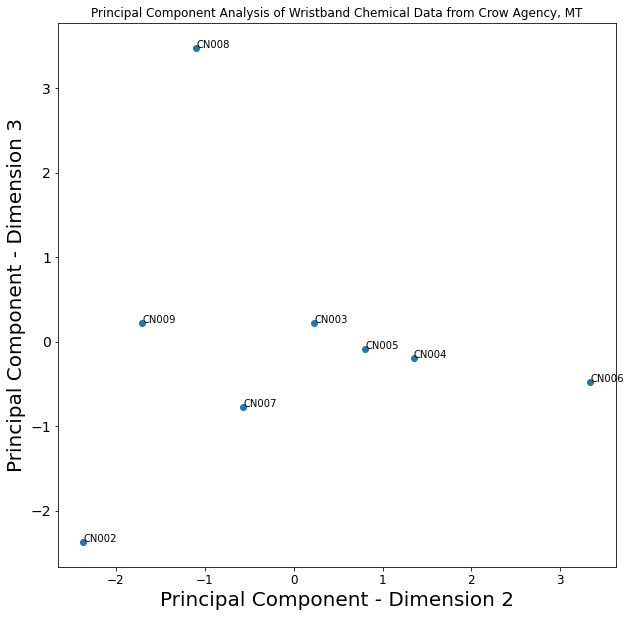

In [11]:
# Plot out samples by how they load on two dimensions of the PCA
def scatter_pca(dimn,dimn2, iloc1, iloc2, pca_df, indexer, title = ''):
    plt.figure(figsize=(10,10))# Set up your plot
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 14) # Set the x and y tick values
    plt.xlabel('Principal Component - {}'.format(dimn), fontsize = 20)
    plt.ylabel('Principal Component - {}'.format(dimn2), fontsize = 20) # Set the x and y labels, using the user given dimension names
    plt.title(title) # add in the title
    plt.scatter(pca_df.loc[:,dimn], pca_df.loc[:,dimn2]) # Make the scatterplot using the user given dimensions
    annotate = list(indexer.index) # Get the index values from your indexer data frame
    for i, label in enumerate(annotate): # for index in the indexer
        xy  = (pca_df.iloc[i,iloc1], pca_df.iloc[i,iloc2]) # Get teh xy location using the index location of your dimensions
        plt.annotate(label, xy = xy) # put the label down
scatter_pca('Dimension 2', 'Dimension 3',1,2, principal_chem_df, chem_data_noctrl, title = 'Principal Component Analysis of Wristband Chemical Data from Crow Agency, MT')


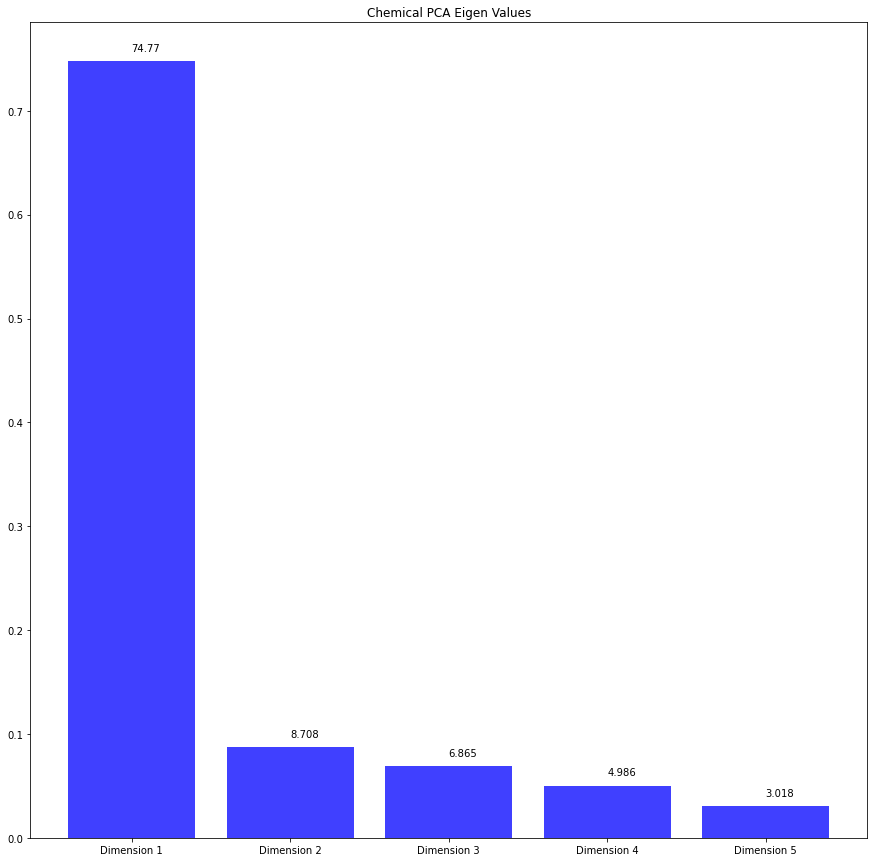

In [12]:
# Plot out eigenvalues from a initial Principal Component Analysis
def plot_eigen(pca_init,title): # Define a function for plotting the eigen values
    eig_vals = pca_init.explained_variance_ratio_ # Get the eigen value ratios
    newdf = pd.DataFrame() # Make an empty data frame
    for x in range(len(eig_vals)): # For x in the range of your eigen values
        newdf.loc['Dimension ' + str((int(x) + 1)),'eig_val'] = float(eig_vals[x]) # row location is the dimension number, second is the 'eig_val' column
    fig, axes = plt.subplots(figsize = (15,15)) # Make your plot window
    axes.bar(x = newdf.index, height= newdf['eig_val'], color = 'blue', alpha = 0.75) # Plot your bar chart 
    for x in range(len(list(newdf.index))): # for x in the range of your dataframe
        plt.text(list(newdf.index)[x],newdf['eig_val'][x] + 0.01,str(newdf['eig_val'][x] * 100)[0:5]) # put your eigen value ration * 100 (percent)
    plt.title(title) # Add in the title
plot_eigen(pca_chem, 'Chemical PCA Eigen Values')

In [13]:
# Get the loadings for each variables
loadings = pd.DataFrame(pca_chem.components_.T, columns = ['Dimension1','Dimension2','Dimension3','Dimension4','Dimension5'], index = chem_ctrl.columns)
loadings

,Dimension1,Dimension2,Dimension3,Dimension4,Dimension5
1-Methylnaphthalene,0.197483,0.029897,0.035607,0.004812,-0.046507
1-Methylphenanthrene,0.165351,-0.164282,-0.210845,-0.082755,0.326576
1-Methylpyrene,0.197911,-0.014988,-0.021456,-0.015783,0.040179
"1,6-Dimethylnaphthalene",0.197483,0.029897,0.035607,0.004812,-0.046507
2-Methylnaphthalene,-0.031770,0.172367,-0.032128,0.601688,0.225606
2-Methylphenanthrene,0.196846,-0.030625,-0.047630,-0.016762,0.074186
"2,4-Di-tert-butylphenol",0.196100,0.016078,0.092812,-0.005458,-0.012696
4-Isopropylphenol,0.197483,0.029897,0.035607,0.004812,-0.046507
9-Fluorenone,0.197167,-0.012977,-0.042266,0.022526,0.072050
"9,10-Anthraquinone",0.197483,0.029897,0.035607,0.004812,-0.046507


In [14]:
# Compute the loading matrix
loadings = pca_chem.components_.T * np.sqrt(pca_chem.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns = ['Dimension1','Dimension2','Dimension3','Dimension4','Dimension5'], index = chem_ctrl.columns)
loading_matrix

,Dimension1,Dimension2,Dimension3,Dimension4,Dimension5
1-Methylnaphthalene,1.064518,0.054997,0.058159,0.006699,-0.050368
1-Methylphenanthrene,0.891312,-0.302208,-0.344386,-0.115197,0.353689
1-Methylpyrene,1.066822,-0.027572,-0.035046,-0.021970,0.043514
"1,6-Dimethylnaphthalene",1.064518,0.054997,0.058159,0.006699,-0.050368
2-Methylnaphthalene,-0.171252,0.317079,-0.052477,0.837568,0.244336
2-Methylphenanthrene,1.061084,-0.056337,-0.077798,-0.023333,0.080345
"2,4-Di-tert-butylphenol",1.057062,0.029577,0.151596,-0.007598,-0.013750
4-Isopropylphenol,1.064518,0.054997,0.058159,0.006699,-0.050368
9-Fluorenone,1.062812,-0.023873,-0.069036,0.031357,0.078031
"9,10-Anthraquinone",1.064518,0.054997,0.058159,0.006699,-0.050368


Read in Independent Land Use Variables

In [15]:
import pandas as pd

LU_data = pd.read_csv('Data/gis_landUseData (1).csv')
def LU_recode(df_series): # Recode Land Use_Land Cover function (this is only optimized for the values I have, in future runs the user can add or replace values as needed)
    if df_series == 'Grassland': # conditional statememt
        x = 0 # recoded value
    if df_series == 'Developed':
        x = 1
    if df_series == 'Shrubland':
        x = 2
    return(x)

LU_data['Recoded_LandCov'] = LU_data['LandCover'].apply(LU_recode)
LU_data = LU_data.drop(['description','TWE','Unnamed: 15', 'LandCover', 'bufferArea_m','sum_roadLength_km'],1)
LU_data = LU_data.set_index('siteID')
LU_data

C:\Users\chris\AppData\Local\Temp/ipykernel_13404/365496626.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  LU_data = LU_data.drop(['description','TWE','Unnamed: 15', 'LandCover', 'bufferArea_m','sum_roadLength_km'],1)


,landfill_NEAR_DIST_m,landfill_NEAR_ANGLE_m,sum_roadLength_m,Count_roadLines_insideBuffer,Rail_NEAR_DIST_m,Rail_NEAR_ANGLE-M,HWY_NEAR_DIST,HWY_NEAR_ANGLE,elevation_m,Recoded_LandCov
siteID,,,,,,,,,,
CN002,11.44,-110.06,0.00,0.0,574.33,14.16,617.33,6.03,952.37,0
CN003,18.46,-93.36,145.66,1.0,506.55,14.16,553.14,4.55,952.37,0
CN004,724.60,-113.86,1944.05,10.0,58.48,4.74,226.68,-41.34,932.18,1
CN005,320.12,-164.02,1032.17,8.0,135.44,14.16,183.00,4.55,929.42,1
CN006,1754.74,-125.62,485.09,1.0,730.93,-175.30,1070.75,-121.46,923.86,0
CN007,2804.10,150.48,0.00,0.0,1520.83,-165.78,1991.31,-133.46,934.44,2
CN008,993.96,-151.41,1883.67,8.0,500.87,-171.12,376.06,-168.04,924.28,1
CN009,904.84,-179.11,1750.54,8.0,410.38,-165.84,331.97,-175.33,923.54,1


In [16]:
# Read in the band site locations
import geopandas as gpd
import pandas as pd
import rasterio
# Define a function to create a buffer then get the attributes from the original shapefile
def join_buff(buff_size, join_file, idfield):
    buffer = join_file.buffer(buff_size)# Make the original buffer
    buffer_1 = gpd.GeoDataFrame(index = [0], crs = join_file.crs, geometry = None) # Set an empty dataframe
    for x in range(len(buffer)): 
        buffer_1.loc[x,'geometry'] = buffer[x] # Set the new dataframes geoemtry to buffer
    buffer_1 = gpd.sjoin(join_file,buffer_1, how = 'inner', op = 'within') # join the buffer GDF with the original shapefile
    buffer_1 = buffer_1.drop_duplicates(idfield) # Drop any duplicates (take care of overlap)
    return(buffer_1)
sites = gpd.read_file(r'Data\bandSites_v2_project.shp') # Read in the sites
TWE = rasterio.open(r'Data\l_tw.tif', 'r') # Read in the TWE layer
windin = rasterio.open(r'Data\l_wi.tif', 'r') # Read in the wind index layer
# Set a 250 m buffer around each
buffer_1 = join_buff(250,sites, 'siteID')
buffer_1

C:\Users\chris\AppData\Local\Temp/ipykernel_13404/803573079.py:8: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  buffer_1 = gpd.GeoDataFrame(index = [0], crs = join_file.crs, geometry = None) # Set an empty dataframe
c:\ProgramData\Anaconda3\envs\geopandas_docs\lib\site-packages\IPython\core\interactiveshell.py:3441: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


,siteID,descriptio,X,Y,PAH2,geometry,index_right
0,CN002,Landfill Site #1,758212.601399,152197.4275,10,POINT (-893043.819 2566515.291),0
7,CN003,Landfill Site #2,758274.161199,152230.4772,17,POINT (-892978.055 2566538.990),0
1,CN005,Church Yard,758640.193599,152296.7095,7,POINT (-892606.058 2566551.013),1
2,CN006,Wastewater Site,759354.522599,153634.9058,2,POINT (-891703.420 2567770.442),2
3,CN007,Weather Station,760775.838499,150608.2660,0,POINT (-890738.903 2564568.399),3
4,CN008,Crow Public School,759205.207499,152684.2020,2,POINT (-891990.153 2566851.763),4
5,CN009,Homesite #1,759238.185599,152157.6768,2,POINT (-892034.451 2566326.056),5
6,CN004,Home Site #2,758625.536499,152871.2408,4,POINT (-892536.619 2567121.533),6


In [17]:
# Get zonal stats from TWE, the windindex and the proximity layer
from rasterstats import zonal_stats
from rasterstats import point_query
from rasterio.transform import Affine
# Get statistics using a buffer with an idfield and a raster file
def get_stats(buffer, raster, idfield):
    stats = pd.DataFrame(zonal_stats(buffer, raster)) # Run zonal stats using the user defined buffer and raster
    stats[idfield] = buffer[idfield] # Set the idfield for stats equal to the buffer field
    return(stats)
twe_stats = get_stats(buffer_1,raster = r'Data\l_tw.tif', idfield = 'siteID') # Get stats from twe
twe_stats = twe_stats.loc[:, ['siteID','mean']] # get only the mean
twe_stats = twe_stats.rename(columns= {'mean':'TWE'}) # rename columns
wind_stats = get_stats(buffer_1, r'Data\l_wi.tif', idfield='siteID') # get stats from the wind index
wind_stats = wind_stats.loc[:,['siteID','mean']] # grab only the mean
wind_stats = wind_stats.rename(columns = {'mean':'windin'}) # rename the mean
TWE.close()
windin.close() # close rasters

In [18]:
trash_prox = rasterio.open(r'Data\prox_trash.tif', 'r') # open the inverse proximity raster
# Define a function to get a value from a raster at point file locations and return the original shapefile attributes
def get_ptst(points, raster, idfield,fieldname):
    stats = pd.DataFrame()# Make an empty data frame
    stats[fieldname] = point_query(points,raster)  # set the user defined field name to the raster value at x point
    stats[idfield] = points[idfield] # set the idfield to be the same as the point idfield
    return(stats)
prox_pt_stats = get_ptst(sites,r'Data\prox_trash.tif','siteID', 'proximity')
trash_prox.close()


In [19]:
print(twe_stats,wind_stats, prox_pt_stats)

  siteID       TWE
0  CN002  0.446812
1  CN005  0.551557
2  CN006  0.537603
3  CN007  0.514047
4  CN008  0.488268
5  CN009  0.502397
6  CN004  0.518677
7  CN003  0.542228   siteID    windin
0  CN002  0.322635
1  CN005  0.324377
2  CN006  0.323301
3  CN007  0.323427
4  CN008  0.318998
5  CN009  0.322149
6  CN004  0.322263
7  CN003  0.322139    proximity siteID
0   0.987133  CN002
1   0.981447  CN005
2   0.901038  CN006
3   0.832752  CN007
4   0.942389  CN008
5   0.943634  CN009
6   0.961505  CN004
7   0.991444  CN003


In [20]:
# Join all the independent variable dataframes
ind_vars = LU_data.merge(twe_stats,how  = 'inner', on = 'siteID')
ind_vars = ind_vars.merge(wind_stats, how = 'inner', on = 'siteID')
ind_vars = ind_vars.merge(prox_pt_stats, how = 'inner', on = 'siteID')
ind_vars = ind_vars.set_index('siteID')
my_vars = ind_vars.loc[:,['sum_roadLength_m','elevation_m','Recoded_LandCov','TWE','windin','proximity']]
ind_vars = ind_vars.drop(['landfill_NEAR_DIST_m'],1)


C:\Users\chris\AppData\Local\Temp/ipykernel_13404/2715957085.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  ind_vars = ind_vars.drop(['landfill_NEAR_DIST_m'],1)


Explore correlation between independent variables, this will include:
    Correlation matrixes between independent variables
    Univariate regressions between each independent variable and the PCA dimensions
    Sensitivity Analysis on size of buffer
    Other explorations

In [21]:
ind_vars.corr()

,landfill_NEAR_ANGLE_m,sum_roadLength_m,Count_roadLines_insideBuffer,Rail_NEAR_DIST_m,Rail_NEAR_ANGLE-M,HWY_NEAR_DIST,HWY_NEAR_ANGLE,elevation_m,Recoded_LandCov,TWE,windin,proximity
landfill_NEAR_ANGLE_m,1.000000,-0.558891,-0.557039,0.865270,-0.212531,0.902295,-0.111815,0.222199,0.545734,0.002366,0.258565,-0.749868
sum_roadLength_m,-0.558891,1.000000,0.950951,-0.619699,-0.172896,-0.639723,-0.400586,-0.659908,0.277573,0.019882,-0.499619,0.201336
Count_roadLines_insideBuffer,-0.557039,0.950951,1.000000,-0.715721,0.048340,-0.710682,-0.177518,-0.576586,0.325669,0.142527,-0.301988,0.314417
Rail_NEAR_DIST_m,0.865270,-0.619699,-0.715721,1.000000,-0.546023,0.968286,-0.388388,0.078783,0.368055,-0.126134,0.125841,-0.836568
Rail_NEAR_ANGLE-M,-0.212531,-0.172896,0.048340,-0.546023,1.000000,-0.475347,0.959970,0.686082,-0.367574,0.059082,0.306477,0.753326
HWY_NEAR_DIST,0.902295,-0.639723,-0.710682,0.968286,-0.475347,1.000000,-0.301675,0.055878,0.363554,0.006053,0.286434,-0.872371
HWY_NEAR_ANGLE,-0.111815,-0.400586,-0.177518,-0.388388,0.959970,-0.301675,1.000000,0.735380,-0.452416,0.125024,0.442025,0.652260
elevation_m,0.222199,-0.659908,-0.576586,0.078783,0.686082,0.055878,0.735380,1.000000,-0.438909,-0.267707,0.133331,0.415966
Recoded_LandCov,0.545734,0.277573,0.325669,0.368055,-0.367574,0.363554,-0.452416,-0.438909,1.000000,0.076106,0.022334,-0.610049
TWE,0.002366,0.019882,0.142527,-0.126134,0.059082,0.006053,0.125024,-0.267707,0.076106,1.000000,0.430971,-0.083139


In [22]:
# Drop any correlated variables over a specified limit
# Caution - this function will drop any variables over your correlation limit. You should determine any variables that you really want to conserve before running this and combine afterwards
def drop_corr(data, corr_lim):
    corr_matrix = data.corr().abs() # get the original correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool)) # Determine the upper triangle of the correlation matrix 
    to_drop = [column for column in upper.columns if any(upper[column] >= corr_lim)] # if any columns to drop, set them here
    if len(to_drop) > 0: # if the to_drop variable is not none
        data.drop(to_drop, axis = 1, inplace = True) # drop variables
        print('Layers Dropped at correlation limit {}:'.format(corr_lim)) # print variables dropped
        for x in range(len(to_drop)):
            print(to_drop[x])
    else:
        print('No Variables to drop at correlation limit {}'.format(corr_lim))
        
drop_corr(ind_vars, 0.65)
ind_vars.corr()

Layers Dropped at correlation limit 0.65:
Count_roadLines_insideBuffer
Rail_NEAR_DIST_m
HWY_NEAR_DIST
HWY_NEAR_ANGLE
elevation_m
proximity


C:\Users\chris\AppData\Local\Temp/ipykernel_13404/3749847447.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool)) # Determine the upper triangle of the correlation matrix


,landfill_NEAR_ANGLE_m,sum_roadLength_m,Rail_NEAR_ANGLE-M,Recoded_LandCov,TWE,windin
landfill_NEAR_ANGLE_m,1.000000,-0.558891,-0.212531,0.545734,0.002366,0.258565
sum_roadLength_m,-0.558891,1.000000,-0.172896,0.277573,0.019882,-0.499619
Rail_NEAR_ANGLE-M,-0.212531,-0.172896,1.000000,-0.367574,0.059082,0.306477
Recoded_LandCov,0.545734,0.277573,-0.367574,1.000000,0.076106,0.022334
TWE,0.002366,0.019882,0.059082,0.076106,1.000000,0.430971
windin,0.258565,-0.499619,0.306477,0.022334,0.430971,1.000000


In [23]:
from scipy.stats import pearsonr

# Determine the correlation between each variable and the first dimension of the PCA
# Define function to get correlation from each predictor variable to the dependent variable
def get_corr(df,df1,depend):
    d = df1[depend] # get the dependent variable from
    newdf = pd.DataFrame(columns=['variable','correlation','p-value']) # assign a new data frame to hold the results 
    for cols in df.columns:
        corr = pearsonr(df[cols],d) # get the pearson correlation
        df2 = {'variable':cols, 'correlation':corr[0], 'p-value':corr[1]} # assign the values to a dictionary
        newdf.loc[len(newdf),:] = df2 # assign the results to the newdf
    return(newdf)
dim_corr = get_corr(my_vars,principal_chem_df,'Dimension 1') 
dim_corr


,variable,correlation,p-value
0,sum_roadLength_m,-0.397571,0.32938
1,elevation_m,0.679927,0.063557
2,Recoded_LandCov,-0.464832,0.245847
3,TWE,0.290016,0.485942
4,windin,-0.054712,0.897619
5,proximity,0.411508,0.311103


Run Stepwise Regression to refine regression formula

In [24]:
# import packages
import numpy as np 
# from sklearn.linear_model import LinearRegression
# from scipy import stats
import statsmodels.api as sm

In [25]:
# # get summary statistics from the regression - prepare for SLR
list_y = list(principal_chem_df['Dimension 1']) # get your Y variable as a list
x  = my_vars # set up your x variables
x['Dimension 1'] = list_y # Put your y var in the x variable dataframe (To get the same index)
X3  = sm.add_constant(my_vars) # Add a constant variable to your X variables
X3 = X3.iloc[:,:len(x.columns) - 1] # select most of your variables (except for Y)
y = x[['Dimension 1']]  # Y equals a dataframe of just your y variable
X2 = sm.add_constant(x) # get a constant in your drop_corr variables
est = sm.OLS(y, X3, missing ='raise') # create the initial regression object
res = est.fit() # fit the regression
x = res.summary() #make x the summary of the regression
print(x)

                            OLS Regression Results                            
Dep. Variable:            Dimension 1   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     4.176
Date:                Thu, 12 May 2022   Prob (F-statistic):              0.204
Time:                        11:51:39   Log-Likelihood:                -14.546
No. Observations:                   8   AIC:                             41.09
Df Residuals:                       2   BIC:                             41.57
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              176.0417    349.706  

c:\ProgramData\Anaconda3\envs\geopandas_docs\lib\site-packages\scipy\stats\_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [26]:
# Backwards Stepwise Linear Regression
def step_reg_bac(y,x, plim = 0.05): 
    pvalues = pd.Series([1]) # Create a pandas series with, assign the only value to one 
    while pvalues[pvalues > plim].all(): # while any of the above series is greater than the p-limit
        est = sm.OLS(y,x) # get an initial regression using all varialbes
        res = est.fit() # fit the regression
        pvalues = res.summary2().tables[1]['P>|t|']
        dropcol = pvalues[pvalues == pvalues.max()].index[0] # assign the drop col to be the column with the highest p-value
        print('Evaluating variable ' + dropcol)
        if len(x.columns) == 1: # Model is not signficant, cannot be improved at all
            pvalues = pd.Series([plim - 1])
            print('Model is not significant')
            break
        if dropcol == 'const': # Don't want to drop the constant
            print("Can't drop Constant variable") 
            est = sm.OLS(y,x.iloc[:,1:]) #Evaluate the regression without the constant
            res = est.fit() # fit the regression again
            pvalues = res.summary2().tables[1]['P>|t|'] # Grab those p-values
            dropcol = pvalues[pvalues == pvalues.max()].index[0] # assign the new p-value
            print('Evaluating ' + dropcol + ' instead')
            if pvalues.max() < plim: # If that value is below the p-value, then the model is significant
                print("Model's already significant")
                break
            elif dropcol != 'const' and pvalues.max() > plim: # otherwise, drop the column and continue
                print('Variable Dropped ' + dropcol + " p-value: " + str(pvalues.max()))
                x = x.drop(dropcol,1)
                continue
        elif pvalues.max() < plim: # Model is significant! 
            print('Model is significant!') 
            break
        else:
            print('Variable Dropped ' + dropcol)
            x = x.drop(dropcol,1) # if the column is not the constant, just drop
    est = sm.OLS(y,x) 
    res = est.fit() # get the final regression significant regression
    return(res)
backwards = step_reg_bac(y,X3) # Run Backwards regression on just your my_vars columns
print(backwards.params)

Evaluating variable sum_roadLength_m
Variable Dropped sum_roadLength_m
Evaluating variable const
Can't drop Constant variable
Evaluating Recoded_LandCov instead
Variable Dropped Recoded_LandCov p-value: 0.5628524113481452
Evaluating variable const
Can't drop Constant variable
Evaluating TWE instead
Model's already significant
const            99.083510
elevation_m       0.428574
TWE             121.468608
windin        -1742.102076
dtype: float64


c:\ProgramData\Anaconda3\envs\geopandas_docs\lib\site-packages\scipy\stats\_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\chris\AppData\Local\Temp/ipykernel_13404/380745064.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = x.drop(dropcol,1) # if the column is not the constant, just drop
c:\ProgramData\Anaconda3\envs\geopandas_docs\lib\site-packages\scipy\stats\_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\ProgramData\Anaconda3\envs\geopandas_docs\lib\site-packages\scipy\stats\_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\chris\AppData

In [40]:
 #Forwards Stepwise Linear Regression - Does not currently work. I'll need to work on this a bit more outside of the class. I did check the results using R's stepwise regression functions
 # forwards regression does not identify any relevant variables for my study. 
def step_reg_for(y,x, plim):
    x_cols = x.columns # get the x columns
    p_vallist = {} # get an empty dictionary for p-values
    est = sm.OLS(y, x['const']) # run the initial regression with only the constant
    res = est.fit() # fir the regression
    run = {'x': 1.0} # set a run variable at 1
    pvalue = 1 # set the first p-value
    newcols = ['const']
    fin = {'const': x['const']} # set the initial regression 
    def get_best(x,y, newcols,x_cols =x_cols):
        x3 = x
        for col in x_cols: # for columns in the original x
            print(col)
            new_x = x.loc[:,newcols.append(col).unique()] # Run the regression with the (constant value, any significant variables) and the new cols 
            est = sm.OLS(y,new_x) # run the regression
            res = est.fit()
            pvalues = res.summary2().tables[1]['P>|t|'] # get the P-value
            # print(pvalues)
            p_vallist[col] = pvalues # add in the p-value to the dictionary'
        exls = []
        # print(p_vallist)
        for key in p_vallist.keys():
            print(run['x'])
            comp = run['x'] # set comp to run[x]
            if type(run['x']) == type(exls): # if run['x'] is a list (i.e., the values have been replaced)
                comp = run['x'][0] # set comp to run['x'][0] instead
            if float(comp) > p_vallist[key][1]: # compare the comp value to the current p-value
                run['x'] = [p_vallist[key][1], key] # set it to the current lowest value # Works up to here!
        fin[run['x'][1]] = run['x'][0] # set the final model results to the lowest p-value column
        X2 = x3.loc[:,list(fin.keys())] # X2 = the list of keys 
        # x = x.drop(run['x'][1],1) # drop the lowest result from x
        # print(comp)
        newcols = newcols.append(run['x'][1])
        # print(newcols)
        # print(X2.columns)
        est = sm.OLS(y,X2) # run the new regression
        res = est.fit()
        pvalue = res.summary2().tables[1]['P>|t|'][1] # get the new smallest p-value
        return(pvalue, newcols) 
    # get_best(x,y)
    while pvalue >= plim : # run this while the p-value is lower than the limit 
        print(pvalue)
        pvalue, newcols = get_best(x,y,newcols = newcols)
    return(res)
        

forward = step_reg_for(y,X3, 0.05)
# print(forward.params)

1
const


AttributeError: 'NoneType' object has no attribute 'unique'

Read in full-scale independent variables 


In [35]:
import rasterio.mask as rm
from shapely.geometry import Polygon
import rasterio
from rasterio.plot import show_hist
import numpy as np
from rasterio.enums import Resampling
twe = rasterio.open(r'Data\extract_twe.tif', 'r+')
windin = rasterio.open(r'Data\extract_lwi.tif', 'r+')
elevation = rasterio.open(r'Data\extract_dem.tif', 'r+') # Read in rasters 
crs = twe.crs # get the CRS (to write the raster later)
transform = twe.transform # get the transform (for the very same reason)
elevation = elevation.read( # reshape the elevation layer 
    out_shape = (
        elevation.count,
        int(twe.height),
        int(twe.width)
    ),
resampling = Resampling.nearest
) # Set the elevation shape to be the same as TWE (this was giving me trouble, so I had to set it)
def setnodata(inras):
    if type(inras).__module__ == 'numpy': # if the type is equal to a numpy array
        inras = inras.astype('float32')  # assign the value to be float_32
        inras[inras == 65535.0] = np.nan # Since we know this is elevation, we can just set it (fix me) 
    else: # for all other counts
        inras = inras.read(1) # read in the numpy array from being a raster
        inras[inras < 0] = np.nan # assign no-data values to nan
    return(inras)
twe = setnodata(twe) # Run the function for each layer
elevation = setnodata(elevation) 
windin = setnodata(windin)

Use raster calculator and regression formula to make predictions

In [28]:
intercept = backwards.params[0] # Get the intercept
elevation_coef = backwards.params[1] # get the elevation coef
twe_coef = backwards.params[2] # get the twe coef
windin_coef = backwards.params[3] # get the wind index coef
# how can we automate this? 

In [29]:
print(backwards.params) 

const            99.083510
elevation_m       0.428574
TWE             121.468608
windin        -1742.102076
dtype: float64


In [36]:
pred =  intercept  + np.dot(windin, windin_coef) + np.dot(twe, twe_coef) + np.dot(elevation, elevation_coef) # put together the equation (again, how can we automate this? )

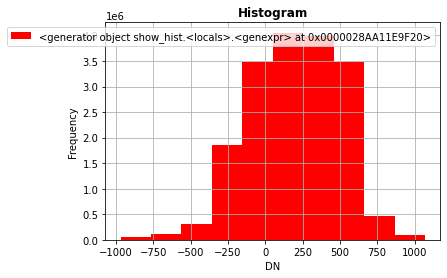

In [37]:
# Show histogram of prediction surface
show_hist(pred)

In [38]:
# Write the raster to a new file 
newdf = rasterio.open(r'Data\prediction_surface.tif','w',driver = 'GTiff',height = twe.shape[0], width=twe.shape[1],dtype = 'float64', crs = crs, transform=transform, count = 1)
newdf.write(pred)

Clip by buffers from from each trash site, then plot out nice pretty maps

In [34]:
import geopandas as gpd
from rasterio.plot import show_hist, show
import pandas as pd
import rioxarray as rxr
import scipy.ndimage as nd
import rasterio as rio
import rasterio
import earthpy.spatial as es
import numpy as np
import rasterio.warp

In [31]:
pred_1 = rasterio.open(r'Data\buff_pred_reproject.tif', 'r') # Open your prediction raster - reproject outside of code as it didn't work; the extract by mask function was also not working correctly so I did that externally as well
pred_sites = gpd.read_file(r'Data\dumps_point.shp') # open the trash sites pointfile
dst_crs = 'EPSG:4326'  # Make sure everything is in this projection, raster stuff is easiest to project outside of code
bounds_1 = pred_1.bounds # Get the bounds of your raster file
pred_1 = np.nan_to_num(pred_1.read(1), pred_1.read(1).min() - 100) # Replace any nan's with a value lower than your rasters minimum value 
crow = gpd.read_file(r'Data\study_area.shp') # read in the study area shapefile
crow = crow.to_crs(dst_crs) # reproject
pred_sites = pred_sites.to_crs(dst_crs) # reproject
bounds = [[bounds_1[1], bounds_1[0]], [bounds_1[3], bounds_1[2]]] # Get the bounds for folium from your raster (very important, must be from your raster)



In [32]:
from folium import raster_layers
import folium
import numpy as np
import matplotlib.cm as cm

In [33]:
locations = pred_sites.geometry # get the geometry of your predictino sites
# locationlist = []
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in pred_sites.geometry] # make a list of all the points in your geometry


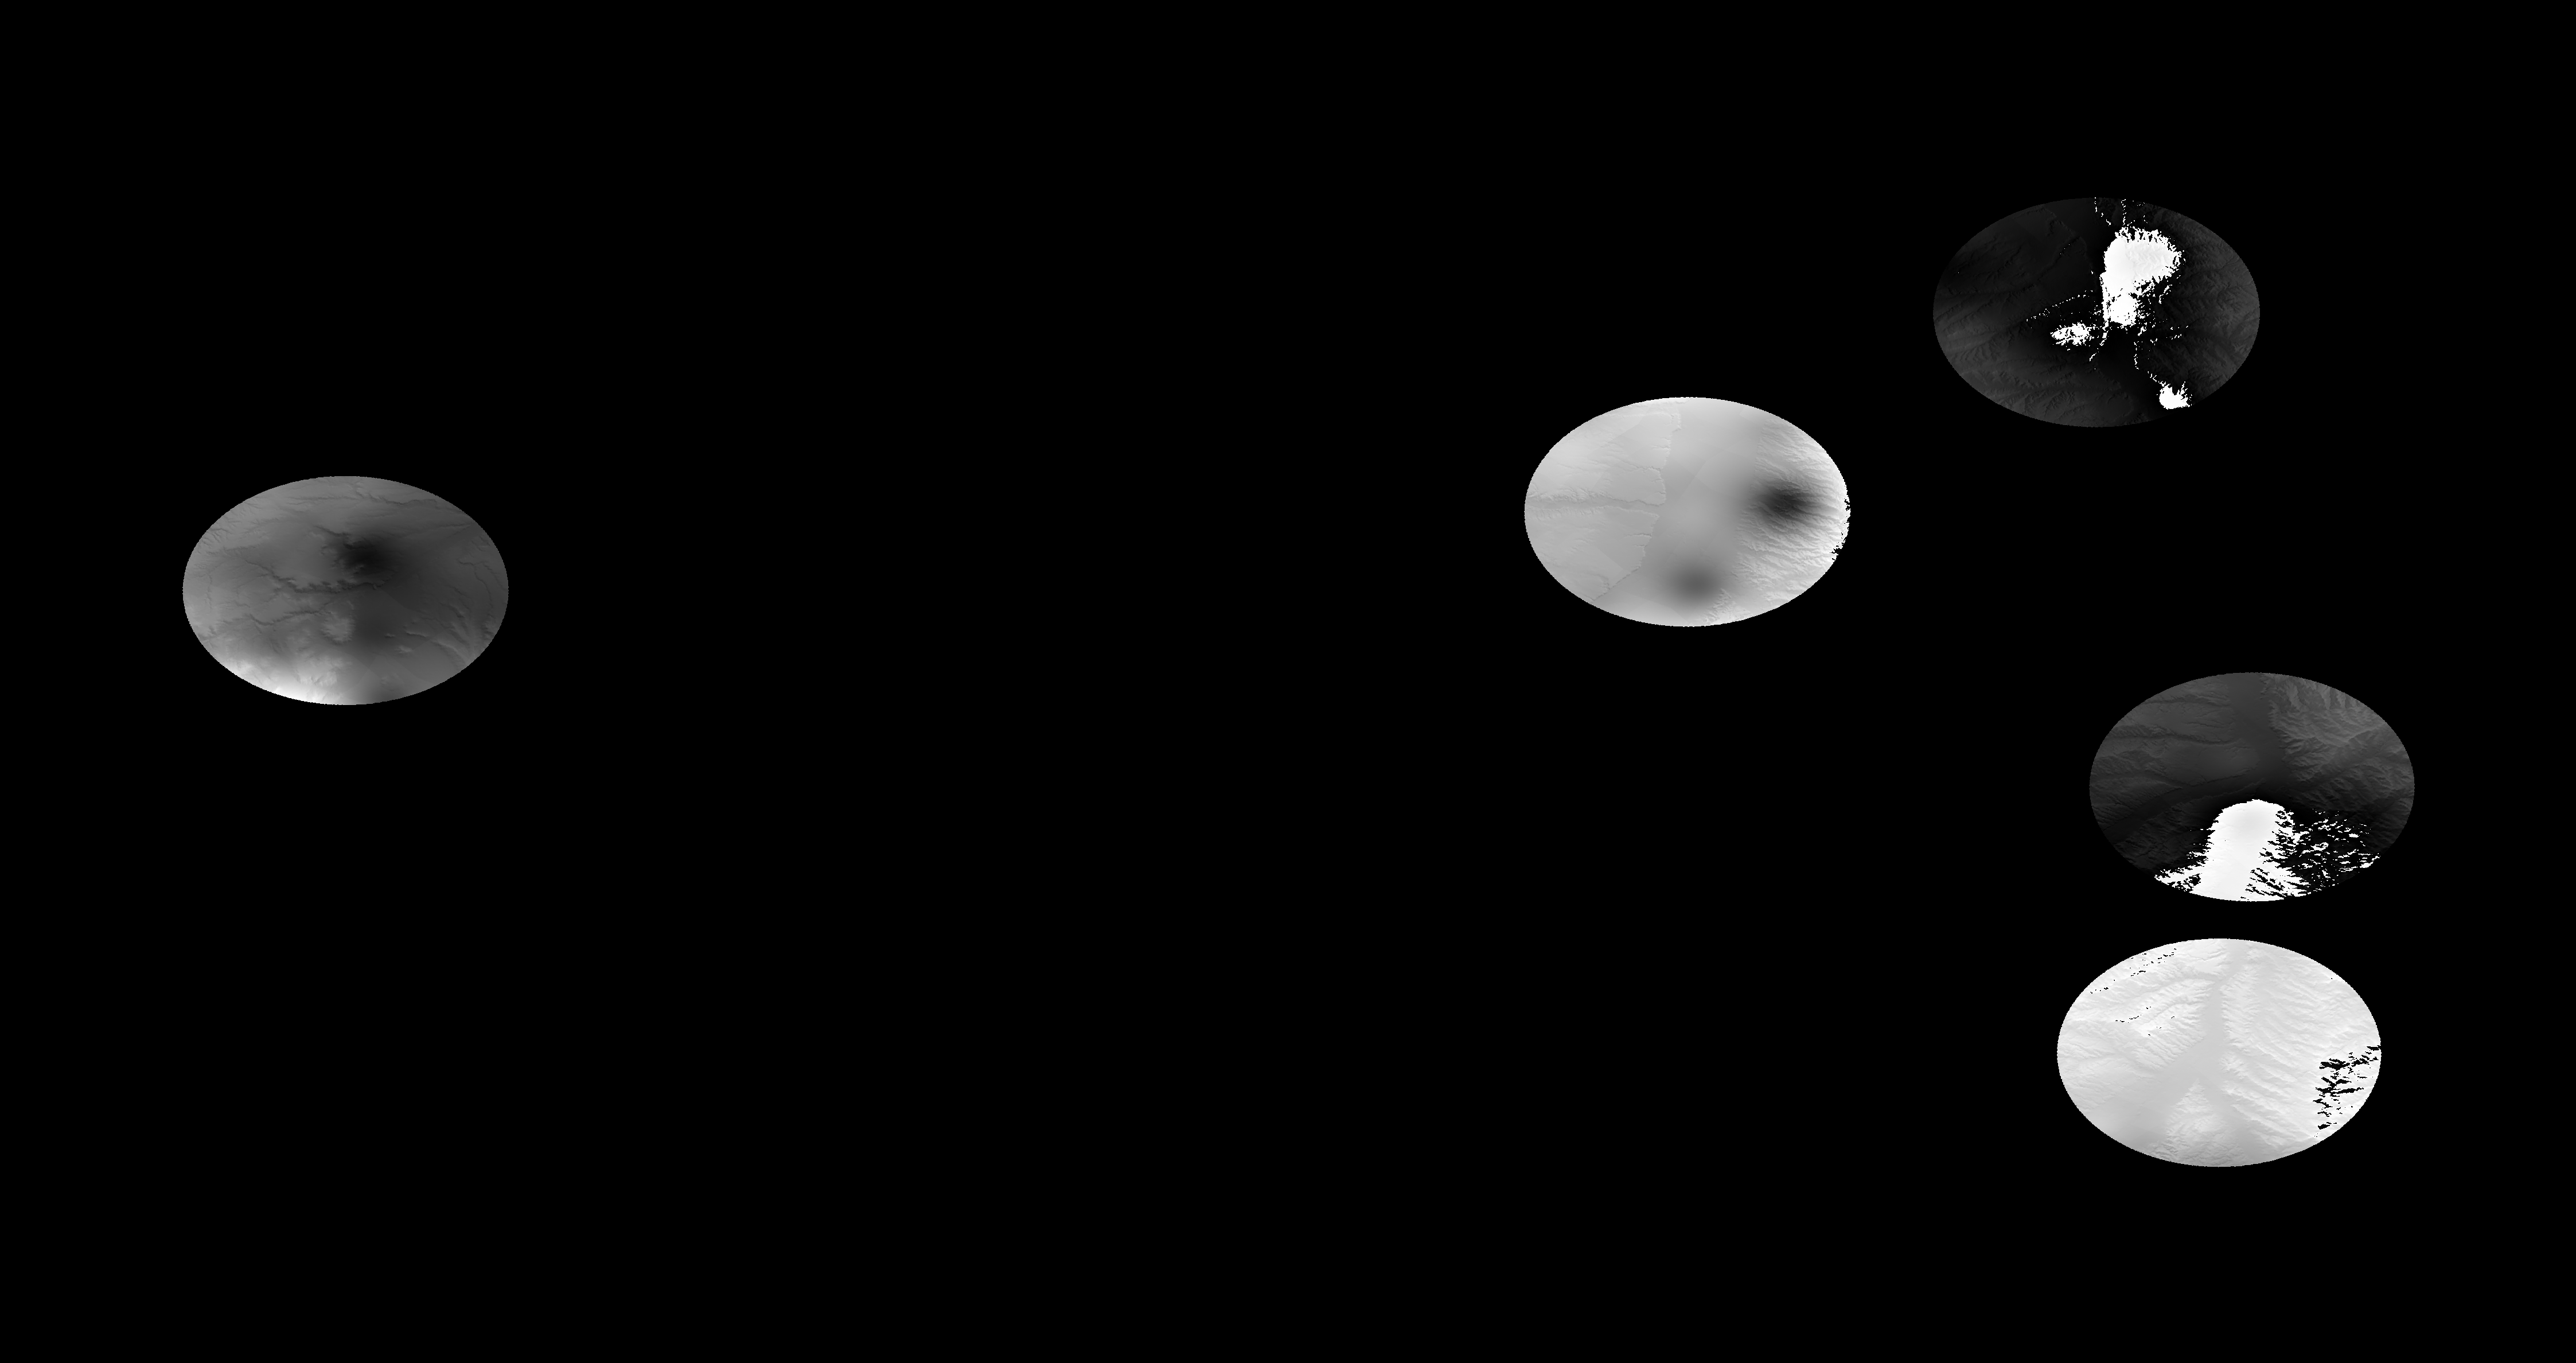

In [34]:
m = folium.Map(location = (pred_sites.loc[0,'geometry'].y ,pred_sites.loc[0,'geometry'].x), zoom_start=10) # initialize the map at your first locatin (it can be moved around)
i = 0 # running counter for displaying points and their popups
m.add_child(raster_layers.ImageOverlay(image = pred_1, bounds = bounds, mercator_project= True)) # overlay the raster file first, make sure it's in the mercator projection
# Adding a colormap also DRAMATICALLY increases the  time it takes for the map to load, expect ~8 min for this image. An easy way to introduce one is using matplotlib.cm's get_cmap() function
for coord in geo_df_list: # run through each geometry in your pred_points
    m.add_child(folium.Marker(location = coord, # add the point 
    popup= "Name: " + str(pred_sites.Name[i]))) # add the popup with the name 
    i += 1 # set the counter variable to be one more than it was
folium.LayerControl().add_to(m) # add Layer control 
m # display map